In [1]:
%pylab inline
import numpy as np
import pylab as pb
import GPy

Populating the interactive namespace from numpy and matplotlib


## Multioutput GP's and Hierarchical modelling

This notebook shows an example with synthethic data of a multioutput GP combined with hierarchical modelling(http://www.biomedcentral.com/1471-2105/14/252)

### Creating Syntethic Data with ICM of GPy

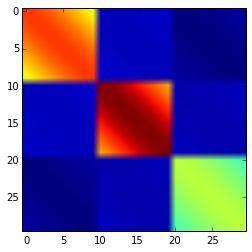

In [2]:
d = 3
time_stamps = 10
kg = GPy.kern.Matern32(1, variance=1., lengthscale=10.)**GPy.kern.Coregionalize(input_dim = 1,output_dim=d, rank=d-1)
kf = GPy.kern.Matern32(1, variance=.01, lengthscale=2.)**GPy.kern.Coregionalize(input_dim = 1,output_dim=d, rank=d-1)

x_parent = np.linspace(0, 2*np.pi, time_stamps)
inp = x_parent[:, None]
T = np.r_[np.c_[inp, np.zeros_like(inp)]]
for i in range(1,d):
    T = np.r_[T, np.c_[inp, np.ones_like(inp)*i]]

#print T
C_parent_gen = kg.K(T, None)
plt.imshow(C_parent_gen)

(30,) (30,)


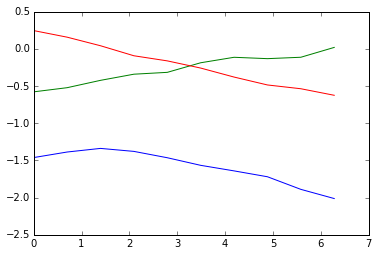

In [3]:
g_mean = np.zeros(T.shape[0])
g_n = np.random.multivariate_normal(g_mean, C_parent_gen, 1)
divs = np.linspace(0,d*time_stamps, d + 1)
print T[0:50,0].shape, g_n[0, 0:50].shape
for i in range(0, divs.shape[0] - 1):
    a = divs[i]
    b = divs[i+1]
    pb.plot(T[a:b,0], g_n[0,a:b])

 /Users/juangilopez/anaconda/lib/python2.7/site-packages/matplotlib/axes/_subplots.py:69: MatplotlibDeprecationWarning:The use of 0 (which ends up being the _last_ sub-plot) is deprecated in 1.4 and will raise an error in 1.5


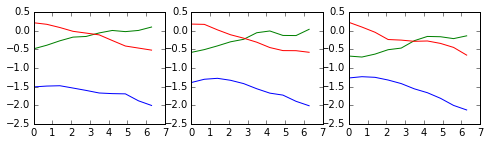

In [4]:
n_sons = 3
fn_list = []
C_sons_gen = kf.K(T, None)
g_n = g_n.squeeze()
plt.figure(1, figsize=(8,2))
for i in range(0,n_sons):
    f_n = np.random.multivariate_normal(g_n, C_sons_gen, 1)
    f_n = np.squeeze(f_n)
    fn_list.append(f_n)
    pb.subplot(n_sons/3, 3, i)
    for j in range(0, divs.shape[0] - 1):
        a = divs[j]
        b = divs[j+1]
        pb.plot(T[a:b,0], f_n[a:b])

### Aranging the data to the Hierarchical GP with ICM

The data is aranged in a way that the first column are the input time points, the second column are the indexes of each output, and the third column contains the index of the replicate

In [5]:
T_hat = np.c_[T, np.zeros_like(T[:,1])]
Y_hat = np.r_[np.c_[fn_list[0]]]
for i in range(1,n_sons):
    T_hat = np.r_[T_hat, np.c_[T, np.ones_like(T[:,1])*i]]
    Y_hat = np.r_[Y_hat, np.c_[fn_list[i]]]

#tmp = np.copy(T_hat[:,2])
#T_hat[:,2] = T_hat[:,1]
#T_hat[:,1] = tmp
#print Y_hat
k1 = GPy.kern.Matern32(1, variance=5., lengthscale=20.)**GPy.kern.Coregionalize(input_dim = 1,output_dim=d, rank=d-1)
k2 = GPy.kern.Matern32(1, variance=2., lengthscale=5.)**GPy.kern.Coregionalize(input_dim = 1,output_dim=d, rank=d-1)
kernels = [k1,k2] 
HGP = GPy.kern._src.independent_outputs.Hierarchical(kernels)
#print T_hat

In [9]:
model = GPy.models.GPRegression(T_hat, Y_hat, HGP) # Making a normal regression
#model.likelihood.variance = 0.01
print kg
print kf
model.optimize('bfgs')#, messages=1)
print HGP

  mul.               |  Value   |  Constraint  |  Prior  |  Tied to
  Mat32.variance     |     1.0  |     +ve      |         |         
  Mat32.lengthscale  |    10.0  |     +ve      |         |         
  coregion.W         |  (3, 2)  |              |         |         
  coregion.kappa     |    (3,)  |     +ve      |         |         
  mul.               |  Value   |  Constraint  |  Prior  |  Tied to
  Mat32.variance     |    0.01  |     +ve      |         |         
  Mat32.lengthscale  |     2.0  |     +ve      |         |         
  coregion.W         |  (3, 2)  |              |         |         
  coregion.kappa     |    (3,)  |     +ve      |         |         
  hierarchy.               |       Value        |  Constraint  |  Prior  |  Tied to
  mul_1.Mat32.variance     |   0.0340144828464  |     +ve      |         |         
  mul_1.Mat32.lengthscale  |     13.7567788532  |     +ve      |         |         
  mul_1.coregion.W         |            (3, 2)  |              |    

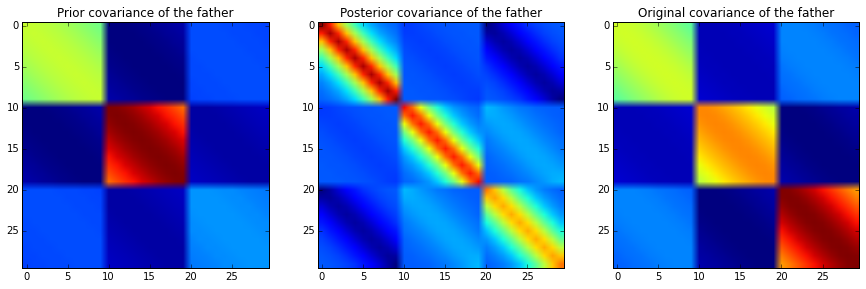

In [17]:
#print T
mu,mvar = model.predict(T, kern=k1, full_cov=True)
C_prior_parent = k1.K(T, None)
plt.figure(1, figsize=(15,6))
plt.subplot(1,3,1)
plt.imshow(C_prior_parent)
plt.title('Prior covariance of the father')
plt.subplot(1,3,2)
plt.imshow(mvar)
plt.title('Posterior covariance of the father')
plt.subplot(1,3,3)
plt.imshow(C_parent_gen)
plt.title('Original covariance of the father')


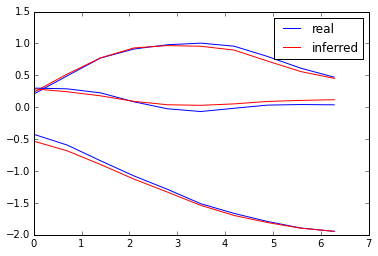

In [18]:
for i in range(0, divs.shape[0] - 1):
    a = divs[i]
    b = divs[i+1]
    blue_line, = pb.plot(T[a:b,0], g_n[a:b], 'b-')
    red_line, = pb.plot(T[a:b,0], mu[a:b], 'r-')
    plt.legend([blue_line, (blue_line, red_line)], ["real", "inferred"])